In [1]:
import pyspark as ps
from pyspark.sql.functions import *
sc = ps.SparkContext(appName="home_work_validation")

In [2]:
from os import path
import time 
import random 
import pandas as pd 
import numpy as np 
import warnings
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql import * #This enables the SparkSession object
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt

spark = SparkSession.builder\
        .master("local") \
        .appName("home_work_validation") \
        .getOrCreate()

## Data upload

In [3]:
output_path = '../data/output/'
input_path = '../data/input/'

# Localidades shapefiles
lsoas = gpd.read_file(input_path + 'localidades_shp/Loca.shp')
lsoas.drop(index = 8, inplace= True )

#Troncales shapefiles
troncal = gpd.read_file(input_path + 'troncal_shape/corredores-troncal-tm.shp')

#Stations 
stations = pd.read_csv(input_path + 'stations.csv')[['station_name', 'latitude', 'longitude']].drop_duplicates(subset =  'station_name')

#hw_locations 
hw_locations = pd.read_csv(output_path + 'tables/hw_location.csv')

#Transactions 
transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv',
                              header =True, sep = ',')

#HW locations
hw_location = spark.read.csv(output_path + 'tables/hw_#location_v2.csv', header =True, sep = ',')

In [4]:
def time_format(df, date_col = 'fechatransaccion', time_col = "horatransaccion"):
    ''' Returns dataframe with date and time as a timespamt format
    Input: 
     - df: PySpark dataframe: Raw transactions
     - date_col: str. Column name for date 
     - time_col: str. Column name for time
     
     Return: 
     PySpark dataframe. 
     Time col:
     - timestamp: time in 'to_timestamp' format '''
    # add time
    df = df.withColumn("timestamp",
        to_timestamp(col(time_col),"HH:mm:ss"))\
        .withColumn("hour", hour(col("timestamp")))\
        .withColumn("minute", minute(col("timestamp")))\
        .withColumn("second", second(col("timestamp")))\
        .withColumn('time', col('hour') + col('minute')/60 + col('second')/3600)
    
    # add date
    df = df.withColumn('date', to_date(unix_timestamp(col(date_col), 'yyyyMMdd').cast("timestamp")))
    return df

In [5]:
def transaction_by_station(transactions, hw_location):
    '''
    Returns the daily home transactions by station
    Input:
    - transactions: Spark dataframe. Row transactions 
    - hw_location : Home and work locations for each frequent user
    ''' 
    
    df = transactions.join(hw_location, on = 'card_id', how = 'outer')

    home_origin = (df['station_name'] == df['home_station']).cast('integer')
    work_origin = (df['station_name'] == df['work_station']).cast('integer')
    other_origin = ((home_origin + work_origin) == 0).cast('integer')

    df = df.withColumn('home_transaction', home_origin)\
           .withColumn('work_transaction', work_origin)\
           .withColumn('other_transaction', other_origin)
    

    home_transactions = df.filter(col('home_transaction') == 1).select(col('station_name'), col('time'))
    work_transactions = df.filter(col('work_transaction') == 1).select(col('station_name'), col('time'))
    other_transactions = df.filter(col('other_transaction') == 1).select(col('station_name'), col('time'))
                      
    return home_transactions, work_transactions, other_transactions

In [6]:
# Home, work and other transactions
transactions = time_format(transactions, date_col = 'fechatransaccion', time_col = "horatransaccion")
home, work, other = transaction_by_station(transactions, hw_location)

In [7]:
%%time
home = home.sample(0.08).cache()
home_df = home.toPandas()

CPU times: user 14.3 s, sys: 778 ms, total: 15.1 s
Wall time: 4min 19s


In [8]:
%%time
work = work.sample(0.08).cache()
work_df = work.toPandas()

CPU times: user 8.45 s, sys: 334 ms, total: 8.79 s
Wall time: 4min 8s


In [9]:
%%time
other = other.sample(0.08).cache()
other_df = other.toPandas()

CPU times: user 10.1 s, sys: 416 ms, total: 10.5 s
Wall time: 4min 14s


In [21]:
home_df = home.toPandas()
work_df = work.toPandas()
other_df = other.toPandas()

## Average transaction time by station type

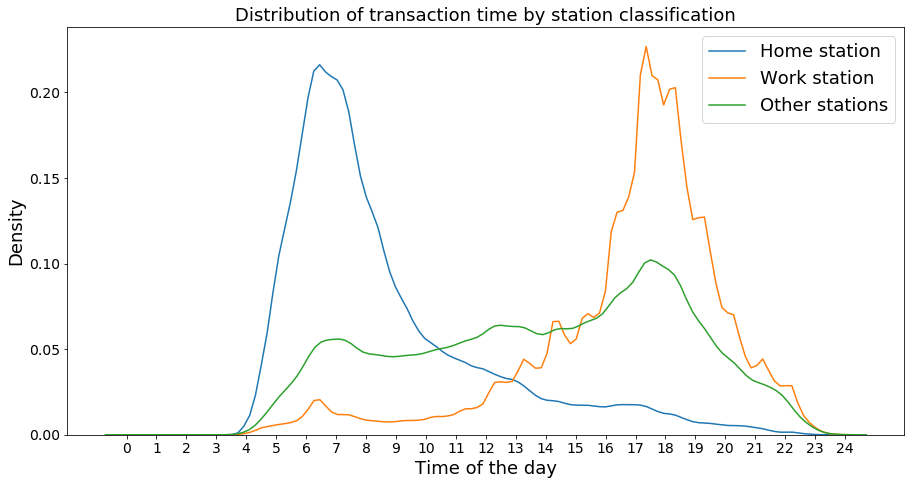

In [13]:
fig, ax = plt.subplots(figsize = (15, 7.5))
sns.kdeplot(home_df.time, label = 'Home station')
sns.kdeplot(work_df.time, label = 'Work station')
sns.kdeplot(other_df.time, label = 'Other stations')

# sns.distplot(transactions_strata[rank_1_filter].transaction_time, )
plt.title('Distribution of transaction time by station classification', fontsize = 18)
plt.xlabel('Time of the day',fontsize = 18)
plt.ylabel('Density',fontsize = 18)
plt.legend(fontsize = 18)
plt.xticks(range(0,25));

fig.savefig(output_path + 'figures/figure-3B.pdf')

## Heatmap

In [11]:
home_df_ = hw_locations.merge(stations, how = 'left', left_on = 'home_station',right_on = 'station_name')
work_df_ = hw_locations.merge(stations, how = 'left', left_on = 'work_station',right_on = 'station_name')
other_df_ = other_df.dropna().merge(stations,  how = 'left', on = 'station_name')

sample_size = 10000
home_ = home_df_.sample(sample_size * 4).dropna()
work_ = work_df_.sample(sample_size).dropna()
other_ = other_df_.sample(sample_size).dropna()

In [44]:
# Obtain get coordiantes
home_df_ = home_df.merge(stations, how = 'left', on = 'station_name')
work_df_ = work_df.dropna().merge(stations,  how = 'left', on = 'station_name')
other_df_ = other_df.dropna().merge(stations,  how = 'left', on = 'station_name')

sample_size = 1000
home_ = home_df_.sample(sample_size * 4).dropna()
work_ = work_df_.sample(sample_size).dropna()
other_ = other_df_.sample(sample_size).dropna()

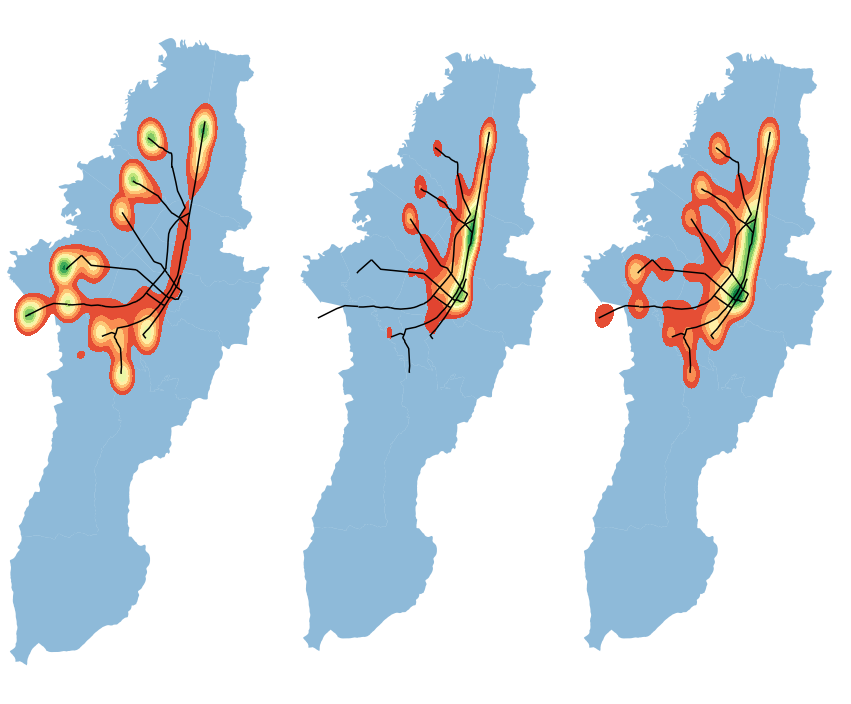

In [14]:
fontsize = 18
shade = True
shade_lowest = False
#Plotting distributions rank 1, rank2 and rank 3 stations. 
f, axes = plt.subplots(nrows = 1, ncols = 3,figsize=(15, 15))

lsoas.plot(alpha=0.5, linewidth=1, axes = axes[0])
sns.kdeplot(home_.longitude ,home_.latitude,shade = shade, 
            shade_lowest=shade_lowest, cmap = 'RdYlGn', ax = axes[0])
troncal.plot(alpha=1, color= 'Black', axes = axes[0])
axes[0].set_axis_off()
# axes[0].set_title("Rank-1 density distribution\n Home stations",
#                       fontsize = fontsize)

lsoas.plot(alpha=0.5, linewidth=1, axes = axes[1])
sns.kdeplot(work_.longitude ,work_.latitude,shade = shade, 
            shade_lowest=shade_lowest, cmap = 'RdYlGn', ax = axes[1])
troncal.plot(alpha=1, color= 'Black', axes = axes[1])
axes[1].set_axis_off()
# axes[1].set_title("Rank-2 density distribution\n Work stations",
#                       fontsize = fontsize)


lsoas.plot(alpha=0.5, linewidth=1, axes = axes[2])
sns.kdeplot(other_.longitude ,other_.latitude,shade = shade, 
            shade_lowest=shade_lowest, cmap = 'RdYlGn', ax = axes[2], fill = False)
troncal.plot(alpha=1, color= 'Black', axes = axes[2])
axes[2].set_axis_off()
# axes[2].set_title("Rank-3 density distribution\n Other stations",
#                       fontsize = fontsize);
plt.subplots_adjust(wspace = 0.02)

f.savefig(output_path + 'figures/figure-3A.pdf')